In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import sys

# Make local src/ importable when running as a script
module_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from maze_env import MazeEnv, dist_to_wall_exact, compute_dead_end_mask, compute_horizontal_corridor_mask, compute_degree_matrix
from maze import Maze
from collections import deque
from scipy.spatial import distance
from queue import PriorityQueue


# -----------------------------
# Environment initialization
# -----------------------------
maze = Maze(10, 10, 0, 0)
env = MazeEnv(
    sz=10, maze=None,
    start=np.array([0.05, 0.05]),
    goal=np.array([0.95, 0.95]),
    reward="distance", log=False, eval=False,
    dt=0.1, horizon=100, wall_penalty=10,
    slide=1, image_freq=100
)

# Masks and degree map for structural reasoning on the grid
dead_mask = compute_dead_end_mask(
    env.maze,
    exits={(int(env.goal[0] * env.sz), int(env.goal[1] * env.sz))}
)
corr_mask = compute_horizontal_corridor_mask(env.maze)
deg_mat = compute_degree_matrix(env.maze)


def generate_positions_balanced(env, num_samples=5000, target_ratio=0.5):
    """
    Generate continuous positions with a balanced mix of 'corridor degree' > 0 vs 0.

    Parameters
    ----------
    env : MazeEnv
    num_samples : int
        Total number of samples to return.
    target_ratio : float in [0,1]
        Desired fraction of samples with degree > 0.

    Returns
    -------
    np.ndarray of shape (num_samples, 2)
        Continuous (x, y) points in [0,1]^2.
    """
    points_zero, points_nonzero = [], []
    while len(points_zero) + len(points_nonzero) < num_samples:
        s = env.sample_open_state_continuous()
        deg = corridor_degree_continuous(env, *s)
        (points_nonzero if deg > 0 else points_zero).append(tuple(s))

        nz_needed = int(num_samples * target_ratio)
        z_needed = num_samples - nz_needed
        if len(points_nonzero) >= nz_needed and len(points_zero) >= z_needed:
            break

    points = points_nonzero[:nz_needed] + points_zero[:z_needed]
    random.shuffle(points)
    return np.array(points, dtype=float)


def is_dead_end_extended(env, x, y, radius=2):
    """
    Heuristic dead-end check around (x, y): count blocked neighbors in a square window.

    Returns True if at least half the window is blocked (out of bounds or fully walled).
    """
    cx, cy = int(x * env.sz), int(y * env.sz)
    blocked_directions = 0

    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            nx, ny = cx + dx, cy + dy
            if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
                blocked_directions += 1
            else:
                cell = env.maze.cell_at(nx, ny)
                if all(cell.walls.values()):
                    blocked_directions += 1

    return blocked_directions >= (radius * radius // 2)


def can_move(env, cx, cy, nx, ny):
    """
    Check whether movement from (cx, cy) to (nx, ny) is possible:
    - target is in-bounds and not fully closed,
    - no blocking walls between the two cells.
    """
    if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
        return False
    if all(env.maze.cell_at(nx, ny).walls.values()):
        return False

    current_cell = env.maze.cell_at(cx, cy)
    next_cell = env.maze.cell_at(nx, ny)
    dx = nx - cx
    dy = ny - cy

    # North
    if dx == 0 and dy == -1 and (current_cell.walls["N"] or next_cell.walls["S"]):
        return False
    # South
    if dx == 0 and dy == 1 and (current_cell.walls["S"] or next_cell.walls["N"]):
        return False
    # East
    if dx == 1 and dy == 0 and (current_cell.walls["E"] or next_cell.walls["W"]):
        return False
    # West
    if dx == -1 and dy == 0 and (current_cell.walls["W"] or next_cell.walls["E"]):
        return False

    return True


def shortest_path_distance(env, x, y):
    """
    A*-like search from continuous (x, y) ∈ [0,1]^2 to the goal cell.
    Returns path length in cell steps, or np.inf if unreachable.
    """
    cx, cy = int(x * env.sz), int(y * env.sz)
    goal_x, goal_y = int(env.goal[0] * env.sz), int(env.goal[1] * env.sz)

    frontier = PriorityQueue()
    frontier.put((0, (cx, cy)))
    cost_so_far = {(cx, cy): 0}

    while not frontier.empty():
        _, current = frontier.get()
        if current == (goal_x, goal_y):
            break

        current_cost = cost_so_far[current]
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = current[0] + dx, current[1] + dy
            if not can_move(env, current[0], current[1], nx, ny):
                continue

            new_cost = current_cost + 1
            if (nx, ny) not in cost_so_far or new_cost < cost_so_far[(nx, ny)]:
                cost_so_far[(nx, ny)] = new_cost
                priority = new_cost + distance.euclidean((nx, ny), (goal_x, goal_y))
                frontier.put((priority, (nx, ny)))

    return cost_so_far.get((goal_x, goal_y), np.inf)


def is_dead_end(env, x, y, dead_mask):
    """Check the precomputed dead-end mask at the cell containing (x, y)."""
    cx = min(int(x * env.sz), env.maze.nx - 1)
    cy = min(int(y * env.sz), env.maze.ny - 1)
    return dead_mask[cy, cx]


def in_horizontal_corridor(env, x, y, corr_mask):
    """Check whether (x, y) lies inside a horizontally closed corridor."""
    cx = min(int(x * env.sz), env.maze.nx - 1)
    cy = min(int(y * env.sz), env.maze.ny - 1)
    return bool(corr_mask[cy, cx])


def cell_degree(env, x, y, deg_mat):
    """Return the traversable degree for the cell containing (x, y)."""
    cx = min(int(x * env.sz), env.maze.nx - 1)
    cy = min(int(y * env.sz), env.maze.ny - 1)
    return int(deg_mat[cy, cx])


# ------------------------------------------------------------------
# Corridor degree along the serpentine path
# ------------------------------------------------------------------
def _build_corridor_maps(env):
    """
    Compute BFS distances (in cell steps) from start and from the actual goal,
    plus the shortest path length between them. Returns (d_start, d_goal, path_len).
    """
    nx, ny = env.maze.nx, env.maze.ny
    start_cell = (0, 0)  # serpentine starts here

    gx = min(int(env.goal[0] * env.sz), nx - 1)
    gy = min(int(env.goal[1] * env.sz), ny - 1)
    goal_cell = (gx, gy)

    def bfs(root):
        dist = np.full((ny, nx), np.inf, dtype=float)
        Q = deque([root])
        dist[root[1], root[0]] = 0
        while Q:
            cx, cy = Q.popleft()
            for dx, dy, w_cur, w_nxt in [(-1, 0, 'W', 'E'), (1, 0, 'E', 'W'),
                                         (0, -1, 'N', 'S'), (0, 1, 'S', 'N')]:
                nx_, ny_ = cx + dx, cy + dy
                if nx_ < 0 or nx_ >= nx or ny_ < 0 or ny_ >= ny:
                    continue
                c, n = env.maze.cell_at(cx, cy), env.maze.cell_at(nx_, ny_)
                if c.walls[w_cur] or n.walls[w_nxt]:
                    continue
                if dist[ny_, nx_] == np.inf:
                    dist[ny_, nx_] = dist[cy, cx] + 1
                    Q.append((nx_, ny_))
        return dist

    d_start = bfs(start_cell)
    d_goal = bfs(goal_cell)
    path_len = d_start[goal_cell[1], goal_cell[0]]  # ∞ if unreachable
    return d_start, d_goal, path_len


def corridor_degree_continuous(env, x, y):
    """
    Return a normalized progress value along the serpentine path:
      - 0.0 for dead corridors or off-path cells,
      - in [0, 1] along the optimal path from start (0) to goal (1).
    """
    if not hasattr(env, "_corr_maps"):
        env._corr_maps = _build_corridor_maps(env)

    d_start, d_goal, path_len = env._corr_maps
    if np.isinf(path_len):
        return 0.0

    cx = min(int(x * env.sz), env.maze.nx - 1)
    cy = min(int(y * env.sz), env.maze.ny - 1)

    ds = d_start[cy, cx]
    dg = d_goal[cy, cx]

    # Off-path if unreachable from start/goal or not on any shortest path
    if np.isinf(ds) or np.isinf(dg) or abs((ds + dg) - path_len) > 1e-6:
        return 0.0

    # On-path cell: normalize progress
    return float(ds / path_len)


def compute_scores(env, positions):
    """
    For each (x, y), compute:
      - distance_to_goal
      - distance_from_wall (exact)
      - degree (corridor progress)
      - path_distance (A* steps to goal)
    """
    scores = []
    goal = np.array(env.goal)

    for x, y in positions:
        distance_to_goal = np.linalg.norm(goal - np.array([x, y]))
        distance_from_wall = dist_to_wall_exact(env, x, y)
        degree = corridor_degree_continuous(env, x, y)
        path_distance = shortest_path_distance(env, x, y)

        scores.append((x, y, distance_to_goal, distance_from_wall, degree, path_distance))

    return scores


def generate_corridor_points(env, n_per_row=600):
    """
    Return evenly spaced points inside the open rows of the serpentine
    (rows y = 0, 3, 6, 9, ... for step=3).
    """
    pts = []
    for row in range(0, env.maze.ny, 3):    # step=3 in make_maze_fail
        y_c = (row + 0.5) / env.sz          # row center
        xs = np.linspace(0.05, 0.95, n_per_row)
        pts += [(x, y_c) for x in xs if not env.point_collision(x, y_c)]
    return np.asarray(pts, dtype=float)


# -----------------------------
# Point generation
# -----------------------------
points_to_generate_randomly = 4000
points_random = generate_positions_balanced(
    env, num_samples=points_to_generate_randomly, target_ratio=0.5
)

point_to_generate_corridor = 20
points_corridor = generate_corridor_points(env, n_per_row=point_to_generate_corridor)

# Extra cluster near the goal (for emphasis)
extra = [(np.random.uniform(0.90, 0.99), np.random.uniform(0.90, 0.99)) for _ in range(50)]

positions = np.vstack([points_random, points_corridor, extra])

# -----------------------------
# Scoring and saving
# -----------------------------
scores = compute_scores(env, positions)
df_positions = pd.DataFrame(
    scores,
    columns=["x", "y", "distance_to_goal", "distance_from_wall", "degree", "path_distance"]
)

# Normalize each metric to [0, 1] for comparability
df_positions["distance_to_goal"] /= df_positions["distance_to_goal"].max()
df_positions["distance_from_wall"] /= df_positions["distance_from_wall"].max()
df_positions["degree"] /= df_positions["degree"].max()
df_positions["path_distance"] /= df_positions["path_distance"].max()

# Normalized distance to the vertical gate (the column where the block-to-block link sits)
varco_col = df_positions["y"].mul(env.sz).floordiv(3)      # 3-row blocks
direction = (varco_col % 2 == 0)                           # True ⇒ moving right
col_varco = np.where(direction, 1.0, 0.0)                  # gate column in normalized x ∈ {0,1}
df_positions["distance_to_gate"] = np.abs(df_positions["x"] - col_varco)
df_positions["distance_to_gate"] /= df_positions["distance_to_gate"].max()

df_positions.to_parquet("positions.parquet", index=False)


Creating Path with step 3


In [ ]:
all_xy_positions = df_positions[["x", "y"]].values
mean_val = np.mean(all_xy_positions, axis=0)
std_val = np.std(all_xy_positions, axis=0)
np.savez("norm_stats.npz", mean=mean_val, std=std_val)
print(f"Salvate statistiche di normalizzazione: media={mean_val}, std={std_val}")

Salvate statistiche di normalizzazione: media=[0.51077099 0.50266612], std=[0.29435121 0.29677286]


/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_81496/1265218740.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


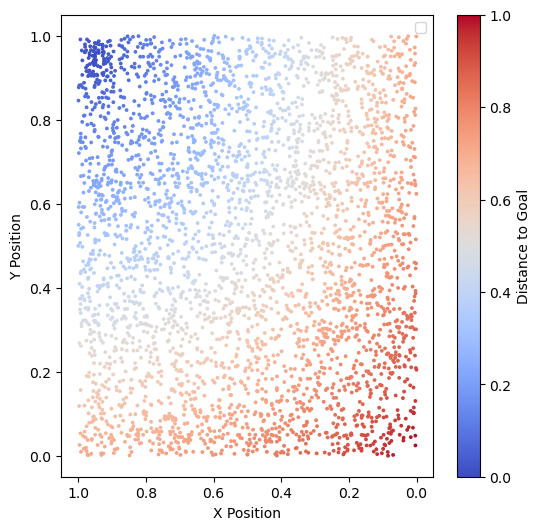

In [11]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_to_goal"], cmap="coolwarm", s=3)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
#plt.title("Randomly Sampled Positions in the Maze (colored by distance to goal)")
plt.colorbar(label="Distance to Goal")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_81496/3911844767.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


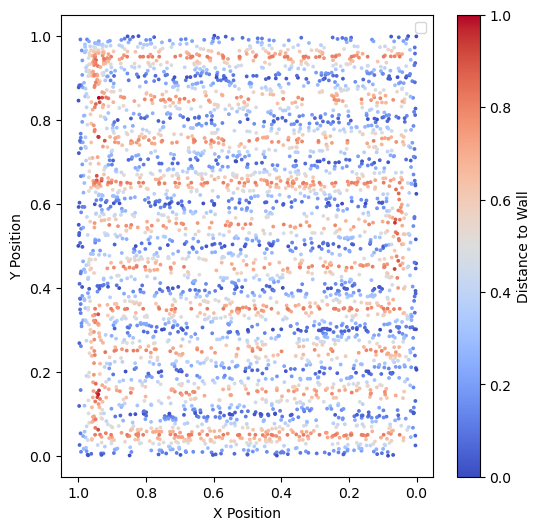

In [ ]:
# Nice plot 
plt.figure(figsize=(6,6))

plt.scatter(df_positions["x"], df_positions["y"],
            c=df_positions["distance_from_wall"],
            cmap="coolwarm", s=3, # linewidths=0, alpha=0.6,
            vmin=0, vmax=1)       

plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
#plt.title("Randomly Sampled Positions in the Maze (colored by distance to wall)")
plt.colorbar(label="Distance to Wall")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_81496/628986767.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


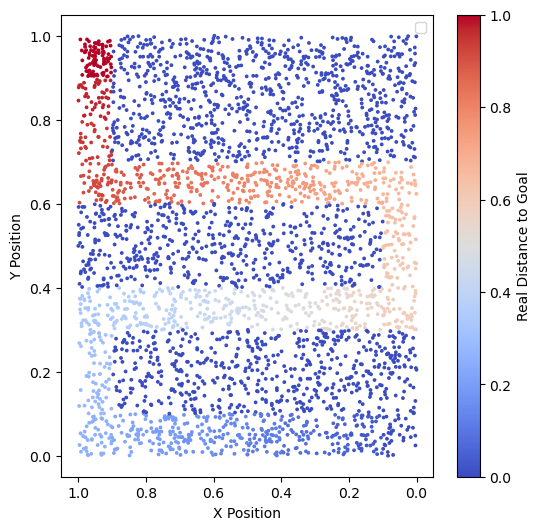

In [ ]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"],
            c=df_positions["degree"],
            cmap="coolwarm", vmin=0, vmax=1, s=3)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.colorbar(label="Real Distance to Goal")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_81496/1988883639.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


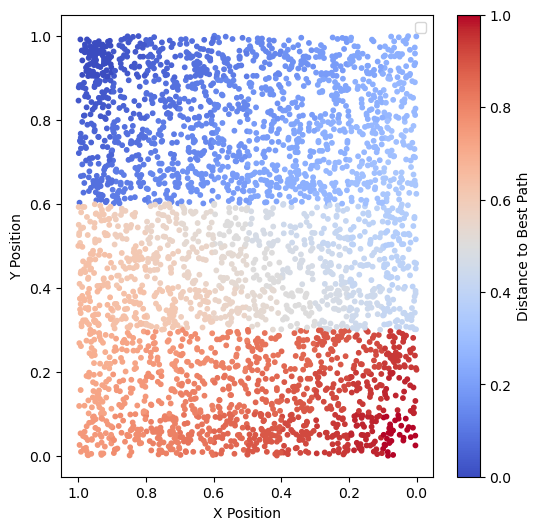

In [ ]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["path_distance"], cmap="coolwarm", s=10)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.colorbar(label="Distance to Best Path")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_81496/2039791905.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


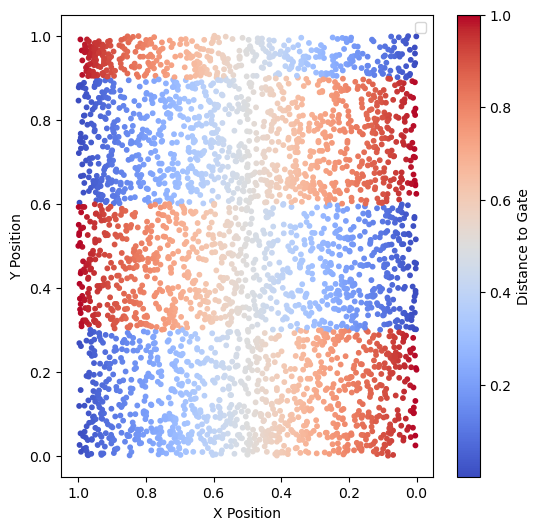

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_to_gate"], cmap="coolwarm", s=10)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.colorbar(label="Distance to Gate")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_81496/576437082.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


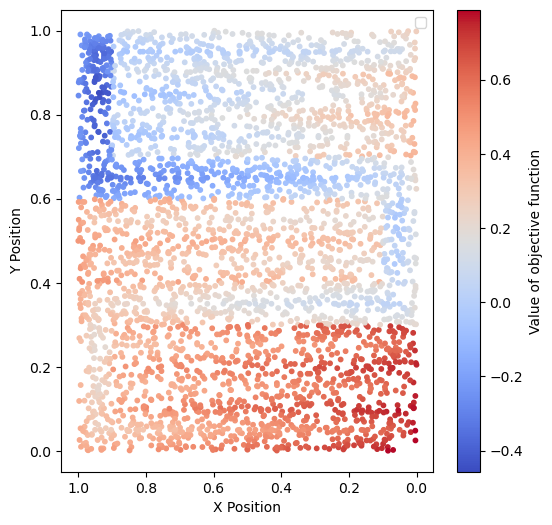

In [ ]:
w_path, w_wall, w_goal, w_deg, w_gate = 0.5, 0.2, 0.2, 0.3, 0.1

df_positions["total_score"] = (
      w_path * df_positions.path_distance      
    + w_goal * df_positions.distance_to_goal       
    - w_deg  * df_positions.degree        
    - w_wall * df_positions.distance_from_wall      
    + w_gate * df_positions.distance_to_gate
)


plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["total_score"], cmap="coolwarm", s=10)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.colorbar(label="Value of objective function")
plt.show()